# Simple TESPy heat pump model

## Introduction

In this section we will build a thermodynamic simulation model of the heat pump to determine the efficiency as function
of the ambient air temperature. For that, we build a TESPy model following the information from the flowsheet in figure
{ref}`tespy-heat-pump-flowsheet`.

```{figure} /figures/heat_pump.svg
---
alt: Component based thermodynamic model of the heat pump in TESPy
name: tespy-heat-pump-flowsheet
---
Component based thermodynamic model of the heat pump in TESPy
```

The table summarizes the assumptions made for the heat pump model.

| parameter description   | model location | model parameter | value | unit |
|:----------------------- |:-------------- |:--------------- | -----:|:---- |
| compressor efficiency   | compressor     | `eta_s`         |    80 | %    |
| evaporation temperature | 2              | `T`             |    10 | °C   |
| condensation temperatre | 4              | `T`             |    50 | °C   |
| heat delivered          | condenser      | `Q`             |   -10 | kW   |

````{note}
The delivered heat value is negative, since heat is extracted from the fluid. The sign convention in TESPy refers to
the open system energy balance, where heat and work transferred over the systems boundary change the enthalpy {math}`h`
of a mass flow {math}`\dot m` between the inlet (1) and the outlet (2):

```{math}
    :label: energy-balance-general
    \dot W + \dot Q = \dot m \cdot \left( h_2 - h_1 \right)
```

With this definition, the sum of work and heat transferred is negative when enthalpy change is negative, which is the
case for the condenser.
````

## Building the model

To build the model we wirst import all dependencies from the `TESPy` library. We need the components shown in the
flowsheet as well as connections to connect them and a network, which does all the pre- and postprocessing as well as
solving the model for us:

In [124]:
from tespy.components import HeatExchangerSimple, CycleCloser, Compressor, Valve
from tespy.connections import Connection
from tespy.networks import Network


Then, we start by defining our working fluid of the heat pump, for example R290 (Propane) and set up the network
instance:

In [125]:
wf = "R290"
nwk = Network(fluids=[wf], p_unit="bar", T_unit="C", iterinfo=False)

Next step is to build the components and the respective connections as indicated in the figure
{numref}`tespy-heat-pump-flowsheet`.

In [126]:
cp = Compressor("compressor")
ev = HeatExchangerSimple("evaporator")
cd = HeatExchangerSimple("condenser")
va = Valve("throttling valve")
cc = CycleCloser("cycle closer")


c0 = Connection(va, "out1", cc, "in1", label="0")
c1 = Connection(cc, "out1", ev, "in1", label="1")
c2 = Connection(ev, "out1", cp, "in1", label="2")
c3 = Connection(cp, "out1", cd, "in1", label="3")
c4 = Connection(cd, "out1", va, "in1", label="4")

Then, we can add the connections to our `Network` instance.

In [127]:
nwk.add_conns(c0, c1, c2, c3, c4)

To run the simulation model, we first have to provide model parameters as described in the table earlier.

In [128]:
# connections
c2.set_attr(T=10)
c4.set_attr(T=50)

# components
cp.set_attr(eta_s=0.8)
cd.set_attr(Q=-10e3)

Besides these parameters, more information are required:

- The fluid's state at the evaporator's and condenser's outlet.
- The pressure values at the same components' inlets.

We can make the following assumptions to add the missing parameters to our model.

| parameter description   | model location | model parameter | value | unit |
|:----------------------- |:-------------- |:--------------- | -----:|:---- |
| saturated gas stream    | 2              | `x`             |   100 | %    |
| saturated liquid stream | 4              | `x`             |     0 | %    |
| pressure losses         | condenser      | `pr`            |   100 | %    |
|                         | evaporator     | `pr`            |   100 | %    |

Finally, we can also specify the fluid mass fractions at any of the connections.

```{note}
The fluid mass fractions have to be provided also, if a network only operates with a single fluid. We are working to
improve the fluid property back-end of the software in other aspects, where this specific setting might change in the
future as well.
```

In [129]:
# connections
c2.set_attr(fluid={wf: 1}, x=1.0)
c4.set_attr(x=0.0)

# components
cd.set_attr(pr=1)
ev.set_attr(pr=1)

## Running the model

Finally, we can solve the model and then have a look at the components' and the connections' results. The
`print_results()` method prints an overview of all results to the terminal.

In [130]:
nwk.solve("design")
nwk.print_results()

##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (Compressor) #####
+------------+----------+----------+----------+--------+
|            |        P |    eta_s |       pr |   igva |
|------------+----------+----------+----------+--------|
| compressor | 1.88e+03 | 8.00e-01 | 2.69e+00 |    nan |
+------------+----------+----------+----------+--------+
##### RESULTS (Valve) #####
+------------------+----------+----------+
|                  |       pr |     zeta |
|------------------+----------+----------|
| throttling valve | 3.72e-01 | 9.59e+10 |
+------------------+----------+----------+
##### RESULTS (HeatExchangerSimple) #####
+------------+-----------+----------+----------+-----+-----+------+------+--------+

To calculate the COP of the heat pump according to the definition in {eq}`cop-heat-pump`, we divide the heat delivered
by the work required in the compressor. The component parameters are available either from the component objects or from
the network's result dataframes. Note, that the compressor's power is saved in the attribute `P`.

In [131]:
cp.P.val

1877.6825194416995

In [132]:
nwk.results["Compressor"].loc["compressor", "P"]

1877.6825194416995

In [133]:
cop = abs(cd.Q.val) / cp.P.val
cop

5.325713956677485

Now, we can make an investigation of the COP at different temperature levels of the heat source side. To do this, we
create a loop and run the model with changing temperature input. On the same loop we can also calculate the widely used
formula for the Carnot COP (eq. {eq}`carnot-cop-heat-pump`) of the heat pump as introduced in the previous chapter. We
can check our assumption of a constant efficiency factor for the heat pump by reordering the eq.
{eq}`cop-heat-pump-carnot-and-efficiency` to the efficiency factor. Then, we plot the results over the temperature range
assessed.


```{math}
    :label: efficiency-heat-pump
    \eta_\text{hp} = \frac{\text{COP}}{\text{COP}_\text{c}}
```

In [134]:
import pandas as pd
import numpy as np


temperature_range = np.linspace(-10, 31, 32)
results = pd.DataFrame(index=temperature_range, columns=["COP", "COP_carnot"])

for T in temperature_range:
    c2.set_attr(T=T)
    nwk.solve("design")
    results.loc[T, "COP"] = abs(cd.Q.val) / cp.P.val
    results.loc[T, "COP_carnot"] = c4.T.val_SI / (c4.T.val - c2.T.val)

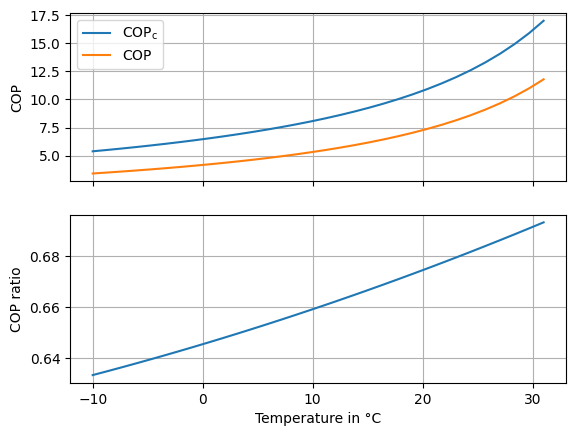

In [135]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(temperature_range, results["COP_carnot"], label="$\mathrm{COP}_\mathrm{c}$")
ax[0].plot(temperature_range, results["COP"], label="$\mathrm{COP}$")
ax[0].set_ylabel("COP")
ax[0].legend()

ax[1].plot(temperature_range, results["COP"] / results["COP_carnot"])
ax[1].set_ylabel("COP ratio")

ax[1].set_xlabel("Temperature in °C")

_ = [_.grid() for _ in ax]
_ = [_.set_axisbelow(True) for _ in ax]

From the graphs we can easily see, that the carnot COP {math}`\text{COP}_\text{c}` is (expectedly) higher than the 
actual COP. However, in the second subplot we see that the efficiency factor {math}`\eta` is not constant.

There are two reasons for this. First, the definition of the Carnot COP in equation (eq. {eq}`cop-carnot-heat-pump`) is
not strictly correct. The effect of this is however only a minor one. The stronger effect is, that the thermodynamic
losses (entropy production due to irreverisbility) in each component are simply higher at lower temperature.

## Preparing the results for the solph model

To make these results usable for our solph model, we can simply export them to a .csv file: